# Digit Recognition Using Scikit-Learn And OpenCV

Digit recognition is Beginner's Project who wants their hands on Machine Learning as well as Computer Vision.

In [1]:
import cv2  # Open CV Library for Image Processing

import numpy as np  #  Numpy numeric Calcualation

import matplotlib.pyplot as plt # Plot Image in Notebook

from scipy import fftpack,real # Scipy Library to Create Homomorphic Filter

import pandas as pd # Read Data 

from sklearn import svm # To create Scikit Training Model

from skimage.feature import hog # 

from sklearn.externals import joblib
% matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('mnist_train.csv')
labels =np.array(data['label'])
features = np.array(data.drop(['label'],axis=1))
features.shape,labels.shape

((60000, 784), (60000,))

In [4]:
f_ = []
for f in features:
    f_h =  hog(f.reshape(28,28), orientations=9, pixels_per_cell=(14,14),cells_per_block=(1, 1), visualise=False)
    f_.append(f_h)

In [6]:
clf = svm.SVC(kernel='rbf', C=200,gamma=0.01)

In [7]:
clf.fit(f_,labels)

SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[5]


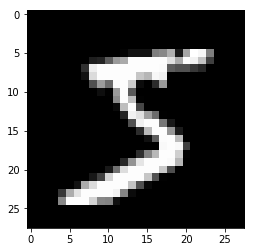

In [9]:
print(clf.predict(f_[0]))
plt.imshow(features[0].reshape(28,28),'gray')

In [10]:
clf.score(f_,labels)

0.90986666666666671

In [11]:
joblib.dump(clf, 'filename.pkl')

['filename.pkl']

In [12]:
clf = joblib.load('filename.pkl')

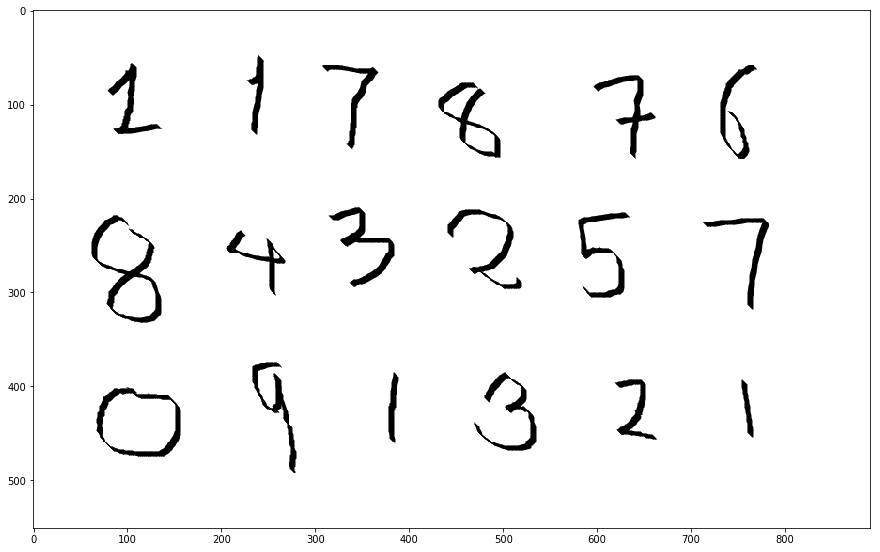

In [13]:
image = cv2.imread('Digit.png') 
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

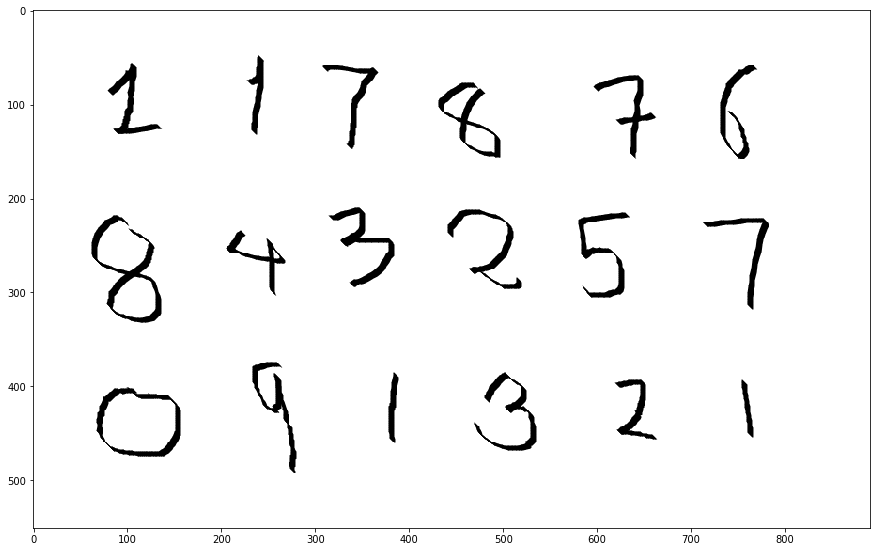

In [14]:
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(15,15))
plt.imshow(gray_image,cmap='gray')

In [15]:
def Homomorphic_Filtering(image,threshold):
    row = image.shape[0]
    col = image.shape[1]
    Log_Image = np.log1p(np.array(image, dtype="float") / 255)

    M = 2*row + 1
    N = 2*col + 1
    sigma = 10

    (X,Y) = np.meshgrid(np.linspace(0,N-1,N),np.linspace(0,M-1,M))

    centerX = np.ceil(M/2)
    centerY = np.ceil(N/2)

    GuassianNumerator = (X - centerX)**2 + (Y - centerY)**2
    L  = np.exp(-GuassianNumerator/(2*sigma*sigma))
    H = 1-L

    Hl_ff  = fftpack.ifftshift(L.copy())
    Hi_ff  = fftpack.ifftshift(H.copy())

    If = fftpack.fft2(Log_Image.copy(),(M,N))
    Ioutlow = real(fftpack.ifft2(If.copy() * Hi_ff, (M,N)))
    Iouthigh = real(fftpack.ifft2(If.copy() * Hi_ff, (M,N)))

    gamma1 = 0.3
    gamma2 = 1.5
    Iout = gamma1*Ioutlow[0:row,0:col] + gamma2*Iouthigh[0:row,0:col]

    Ihmf = np.expm1(Iout)
    Ihmf = (Ihmf - np.min(Ihmf)) / (np.max(Ihmf) - np.min(Ihmf))
    Ihmf2 = np.array(255*Ihmf, dtype="uint8")

    Ithresh = Ihmf2 < threshold
    Ithresh = 255*Ithresh.astype("uint8")
    return Ihmf,Ithresh

In [16]:
filtered_image,threshold_image = Homomorphic_Filtering(gray_image,65)

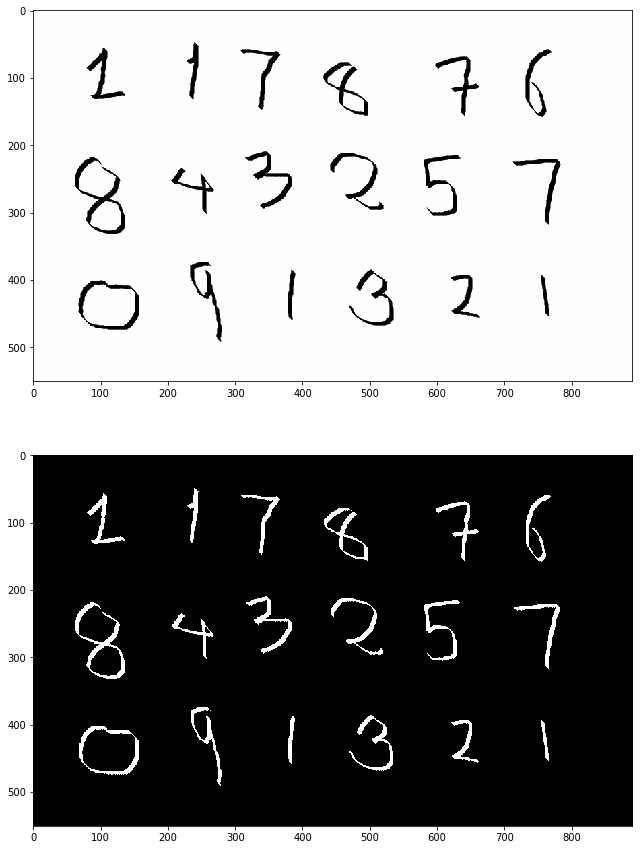

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.imshow(filtered_image,'gray')
plt.subplot(212)
plt.imshow(threshold_image,'gray')

In [18]:
im, cnts, hierarchy = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

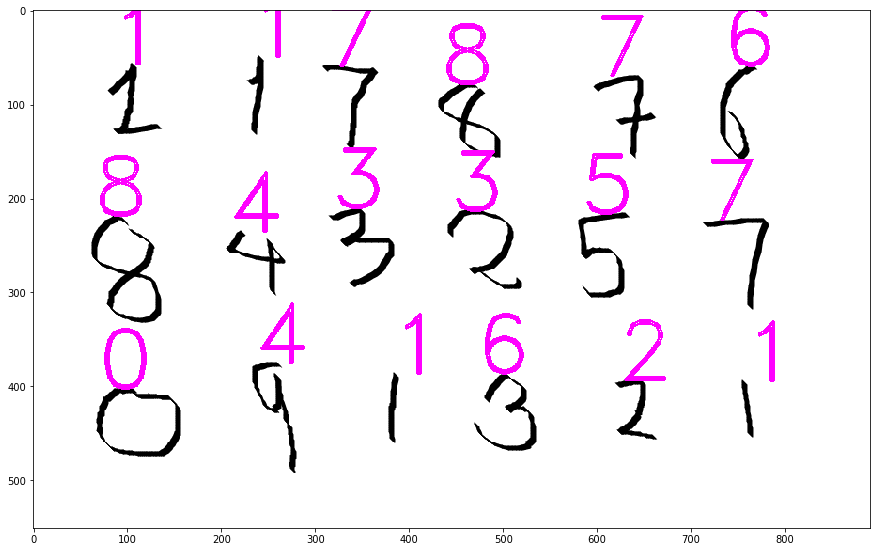

In [19]:
for i,c in enumerate(cnts):
    (x, y, w, h) =  cv2.boundingRect(c)
    length = int(h*1.3)
    Point1 = int(y+h//2-length//2)
    Point2 = int(x+w//2-length//2)
    Im = threshold_image[Point1-2:Point1+length,Point2-2:Point2+length]
    Im = cv2.resize(Im,(28,28),interpolation=cv2.INTER_AREA)
    Im = cv2.dilate(Im,(3,3))
    Im_ = hog(Im, orientations=9, pixels_per_cell=(14,14),cells_per_block=(1, 1), visualise=False)
    nbr = np.asscalar(clf.predict(Im_))
    cv2.putText(image, str(int(nbr)), (x, y),cv2.FONT_HERSHEY_DUPLEX, 3, (255, 0, 255), 2)
plt.figure(figsize=(15,15))
plt.imshow(image)